# Equities: separable components of total return

## Enterprise and speculative returns, plus dividend yield

We begin by constructing a model for equity price returns
by decomposition into enterprise and speculative returns.
That model is then tested using S&P 500 data going back
to the year 1871 (well-known database assembled by Robert Shiller,
Nobel laureate at Yale).

We find that the popular percentage approximation model is
not appropriate as the time horizon increases.
In contrast, the exactitude of the logarithmic model
is demonstrated by multivariate regression.

The enterprise and speculative returns are then
plotted to understand their respective relationship
to price dynamics. The Great Recession produced
spikes in the data unlike any other in history.

Total return is thus the sum of enterprise and speculative returns,
plus dividend yield.
We examine the dividend payout ratio relative
to earnings, and find a local estimate for forecasting.

Finally we demonstrate forecasting using the above
decomposition of returns and the most recent data.
Those results are then compared to an univariate
Holt-Winters time-series model in Appendix 1.

Appendices 2 and 3 covers the historical characteristics
of the three separable components of total return.

Reference section briefly relates our findings to Bogle (2015).

VIEWING: *if you encounter this message,*
[Math Processing Error], *it means
GitHub is timing out on rendering LaTeX equations.
Please view this notebook at*
[Jupyter](http://nbviewer.jupyter.org/github/rsvp/fecon235/blob/master/nb/qdl-spx-earn-div.ipynb)
instead. Issue [#3](https://github.com/rsvp/fecon235/issues/3)
has been raised in this regard.

*Dependencies:*

- Repository: https://github.com/rsvp/fecon235
- Python: matplotlib, pandas

*CHANGE LOG*

    2016-03-30  Raise LaTeX math issue #3, and provide alternative Jupyter view.
                   Total return summary revised.
    2016-03-28  Refactor data retrieval to yi_quandl module.
    2016-03-18  Rough draft, test data source directly.

In [1]:
from fecon235.fecon235 import *

In [2]:
#  PREAMBLE-p6.15.1223 :: Settings and system details
from __future__ import absolute_import, print_function
system.specs()
pwd = system.getpwd()   # present working directory as variable.
print(" ::  $pwd:", pwd)
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option( 'display.notebook_repr_html', False )
#  Beware, for MATH display, use %%latex, NOT the following:
#                   from IPython.display import Math
#                   from IPython.display import Latex
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  Generate PLOTS inside notebook, "inline" generates static png:
%matplotlib inline   
#          "notebook" argument allows interactive zoom and resize.

 ::  Python 2.7.11
 ::  IPython 4.0.0
 ::  jupyter 1.0.0
 ::  notebook 4.0.6
 ::  matplotlib 1.4.3
 ::  numpy 1.10.1
 ::  pandas 0.17.1
 ::  pandas_datareader 0.2.0
 ::  Repository: fecon235 v4.16.0221 devBogleSPX
 ::  Timestamp: 2016-03-29, 19:25:13 UTC
 ::  $pwd: /media/yaya/virt15h/virt/dbx/Dropbox/ipy/fecon235/nb


## Equities model without interest rates

We will test a model for equity price returns which shall
exclude the usual considerations for interest rates,
the discounting of dividends, and the so-called "equity risk premium."

Let us begin with the obvious:

$$ p_t = x_t s_t \qquad\hbox{where}\quad  s_t = p_t / x_t $$

Price per share at time t will be represented by $p_t$,
and the earnings per share by $x_t$.
Thus $s_t$ is the usual price/earnings ratio.

Taking the log of both sides, we can get two equations for different epochs:

$$ \eqalign{ \log p_t &= \log x_t + \log s_t \cr
   \log p_{t-n} &= \log x_{t-n} + \log s_{t-n} \cr}$$
   
Subtracting the second equation from the first, given $n > 0$, we obtain:

$$ \eqalign{ \log {p_t \over p_{t-n}} &= \log {x_t \over x_{t-n}} + \log {s_t \over s_{t-n}} \cr
   P_t &= X_t + S_t \qquad\hbox{for some implicit  } n.\cr }$$

Note: $\log(1+\psi) \approx \psi$, for small $\psi$ where $\psi$
can be expressed in percentage terms.
The capitalized variables thus can be approximately interpreted as follows:
percentage *price change* $P_t$ is equal to percentage *earnings growth* $X_t$
plus the percentage *change in price/earnings ratio* $S_t$ --
over $n$ periods.

However, more exactly, a ***capitalized variable*** is the difference
in logarithmic values of the lower case variables over $n$ periods.
As we shall see, $X_t$ can be interpreted as **enterprise return**,
whereas $S_t$ can be characterized as **speculative return**.

## Data specification and retrieval

We shall rely upon Quandl [MULTPL](https://www.quandl.com/data/MULTPL)
database which actively updates the famous series made public by
Robert [Shiller](http://www.econ.yale.edu/~shiller/data.htm)
in his Nobel prize-winning work. Shiller keeps his data
in an [Excel spreadsheet](http://www.econ.yale.edu/~shiller/data/ie_data.xls),
but our downloaded data will be in pandas Dataframe format.
We have also doubled-checked the data with CSV formatted
[okfn.org](http://data.okfn.org/data/core/s-and-p-500)
and its GitHub [datasets](https://github.com/datasets/s-and-p-500)
repository.

The economics department at Yale also maintains the Shiller database
at Quandl [YALE](https://www.quandl.com/data/YALE/SPCOMP-S-P-Composite),
but unfortunately, there seems to be a nine month latency.
Here is **Shiller's own description of the data:**

> "Stock market data used in my book, *Irrational Exuberance*
[Princeton University Press 2000, Broadway Books 2001, 2nd ed., 2005]
are available for download: U.S. Stock Markets 1871-Present and CAPE Ratio.
This data set consists of **monthly** stock price, dividends, and earnings
data and the consumer price index (to allow conversion to real values),
all **starting January 1871**. The price, dividend, and earnings series
are from the same sources as described in Chapter 26 of my earlier book
(*Market Volatility* [Cambridge, MA: MIT Press, 1989]),
although now I use monthly data, rather than annual data.
Monthly dividend and earnings data are computed from the
S&P four-quarter totals for the quarter since 1926,
with linear interpolation to monthly figures.
Dividend and earnings data before 1926 are from Cowles and associates, 
*Common Stock Indexes* [2nd ed. Principia Press 1939],
interpolated from annual data.
Stock price data are monthly averages of daily closing prices."

For our earnings data, we shall ignore Shiller's CAPE ratio,
and instead use the raw *nominal* data (not inflation-adjusted),
although *real* data has also been reconstructed by Shiller.

The explicit munging details of the download functions
are located in our *yi_quandl* module.

In [3]:
#  m4 implies monthly frequency:
#                   price:
p = get( m4spx_1871_p )

#                   earnings over 12-months:
x = get( m4spx_1871_e )

#  We want non-inflation adjusted data for this notebook.

In [4]:
#  Compute price/earnings ratio:
s = todf( p / x )

In [5]:
#  Apply numpy natural logarithm:
plog = np.log( p )
xlog = np.log( x )
slog = np.log( s )

### Shape the data: endpoints, n, and transform methods

**START** specific tests from the next cell:

In [6]:
#  RE-RUN the REGRESSION starting from this cell, varying specs:

#  Raw data starts 1871-01-01, but shall allow lags up to 24 months:

start = '1873-01-01'
end   = '2100-01-01'

#  Compute changes over freq of n periods:

n = 12

#  Percentage transform is approximate, but widely used,
#  whereas logarithmic transform gives exact results.
transform = "%"
transform = "log"

In [7]:
## This is the approximate PERCENTAGE transforms: 

if transform == "%":
    P  = div( pcent(p, n), n ) * 12
    X  = div( pcent(x, n), n ) * 12
    S  = div( pcent(s, n), n ) * 12

#  div() is our numpy function for Python 2 and 3 division.
#  The div() and the 12 annualizes the percentage.

In [8]:
## This is the exact LOG differencing transforms: 

if transform == "log":
    P  = div( dif(plog, n), n ) * 12
    X  = div( dif(xlog, n), n ) * 12
    S  = div( dif(slog, n), n ) * 12

#  div() is our numpy function for Python 2 and 3 division.
#  The div() and the 12 annualizes the result.

In [9]:
#  Create a mega Dataframe:
mega = paste([ p, x, s, P, X, S ])

#  Then name the columns:
mega.columns = ["p", "x", "s", "P", "X", "S"]

In [10]:
stats( mega )

                 p            x            s            P            X  \
count  1730.000000  1730.000000  1730.000000  1730.000000  1730.000000   
mean    228.468734    11.832738    15.599659     0.042127     0.037805   
std     448.612672    22.093790     8.433497     0.185736     0.291122   
min       2.730000     0.159970     5.310000    -1.067382    -2.175001   
25%       7.772500     0.550071    11.310000    -0.064418    -0.075170   
50%      15.960000     1.290224    14.645000     0.063599     0.052257   
75%     110.875000    12.562169    17.870000     0.169694     0.158506   
max    2111.940000   105.966507   123.730000     0.807153     2.189681   

                 S  
count  1730.000000  
mean      0.004322  
std       0.282146  
min      -2.032863  
25%      -0.132400  
50%       0.003927  
75%       0.159135  
max       1.621470  

 ::  Index on min:
p   1877-06-01 00:00:00
x   1894-12-01 00:00:00
s            1917-12-01
P            1932-06-01
X            2009-03-01
S   

## Apply regression to test  model

The correlation matrix above gives us some partial insight
into pairwise relationships. We would expect P and X
to be strongly correlated.

Next we conduct a multivariate regression by specifying the
form of the theoretical model. We suppress estimation of
the intercept by using "0" within regressformula().
Obviously, the coefficients for X and S should
to be close to 1 -- but the results are quite unexpected
for the approximative model.

In [11]:
# Get more info on regression by: regressformula??

result = regressformula( mega[start:end], "P ~ 0 + X + S" )
#                            ^possible truncation of Dataframe

In [12]:
print( result.summary() )

                            OLS Regression Results                            
Dep. Variable:                      P   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.630e+32
Date:                Tue, 29 Mar 2016   Prob (F-statistic):               0.00
Time:                        12:25:27   Log-Likelihood:                 58729.
No. Observations:                1718   AIC:                        -1.175e+05
Df Residuals:                    1716   BIC:                        -1.174e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
X              1.0000   4.54e-17    2.2e+16      0.0

In [13]:
print("Confirming: transform=", transform, ", n=", n, ", start=", start, ", end=", end)

Confirming: transform= log , n= 12 , start= 1873-01-01 , end= 2100-01-01


**END** specific tests from multivariate regression.

---

## Terrible percentage approximation

In many studies, the percentage approximation is used to examine returns,
perhaps because conceptually it is readily understood.
By executing the above regression while *commenting out* the **transform="log"** line,
we can replicate the following results for various n values. As n increases,
the R-squared statistic worsens considerably and the coefficients deviate farther away
from the theoretical value of 1. Let $\varepsilon_t$ be the estimation error, then:

$$\eqalign{
\varepsilon_t &= \hat{P_t} - P_t \cr
\hat{P_t} &= 0.78 X_t + 0.91 S_t + \varepsilon_t \qquad \hbox{for  } n=1 \quad R^2=0.90 \cr
\hat{P_t} &= 0.41 X_t + 0.61 S_t + \varepsilon_t \qquad \hbox{for  } n=3 \quad R^2=0.57 \cr
\hat{P_t} &= 0.19 X_t + 0.30 S_t + \varepsilon_t \qquad \hbox{for  } n=6 \quad R^2=0.27 \cr
\hat{P_t} &= 0.15 X_t + 0.23 S_t + \varepsilon_t \qquad \hbox{for  } n=12 \quad R^2=0.21 \cr
}$$

The errors can be traced to the data reality that $\psi$
cannot be assumed to be small, for there were indeed some
extreme changes in the course of 143 years.
Lengthening $n$ also contributes to violating that
numerical approximation.

## Exact results using log transform

Thankfully the data (and algorithms) confirm the mathematical
derivation of our model when the **transform="log"** line is in effect:

$$\eqalign{
\hat{P_t} &= 1.00 X_t + 1.00 S_t + \varepsilon_t \qquad \hbox{for all  } n \quad R^2=1.00 \cr
}$$

Increasing $n$ has no effect on our results, which was entirely expected.
This can be verified by re-executing the appropriate sections
of this notebook with different parameters.

In view of our findings, we make the this revision:
**the *logarithmic* price change $P_t$ is *exactly* equal to the
*logarithmic* earnings change $X_t$
plus the change in *logarithmic* price/earnings ratio $S_t$ --
over $n$ periods.**

The pairwise correlations, however, were somewhat surprisingly low.
For example, for $n=12$, the correlation between $P_t$ and $X_t$
was 0.37, and the correlation between $P_t$ and $S_t$ was 0.28.
But of course, as an ensemble, they mesh together perfectly.

## Further details regarding X and S

The two variables $X_t$ and $S_t$ have the same functional form
and the same coefficient weights, yet
the mean of the former is 0.03781 and
the mean of the latter 0.00432,
which differs by a factor of 8.75 (when $n=12$).
This indicates **earnings growth contributes far more
to price appreciation than variation in the price/earnings ratio.**
However, in Appendix 2 we see how the volatility of the price/earnings ratio
could obscure this finding over a short observation period.

Since our data has monthly frequency, we shall focus on
cases where $n$ is a multiple of 12.
This is to mitigate the possibility of observing seasonal effects.

Since the logarithms of the raw data are clearly crucial,
let us see their stats:

In [14]:
rawlog = paste([plog, xlog, slog])
rawlog.columns = ["pl", "xl", "sl"]
rawlog = rawlog[start:end]
#  We intentionally use "start" and "end"
#  to remain consistent with above analysis.

stats( rawlog )

                pl           xl           sl
count  1718.000000  1718.000000  1718.000000
mean      3.601719     0.933360     2.668359
std       1.920100     1.785019     0.375661
min       1.004302    -1.832767     1.669592
25%       2.068128    -0.562372     2.423695
50%       2.786243     0.288687     2.686827
75%       4.733979     2.537636     2.884521
max       7.655362     4.663123     4.818102

 ::  Index on min:
pl   1877-06-01 00:00:00
xl   1894-12-01 00:00:00
sl            1917-12-01
dtype: datetime64[ns]

 ::  Index on max:
pl   2015-05-01
xl   2014-09-01
sl   2009-05-01
dtype: datetime64[ns]

 ::  Head:
                           pl        xl        sl
T                                                
1873-01-01 00:00:00  1.631199 -0.843657  2.474856
1873-02-01 00:00:00  1.638997 -0.820592  2.459589
1873-03-01 00:00:00  1.631199 -0.820667  2.451867
1873-04-01 00:00:00  1.617406 -0.820584  2.437990
1873-05-01 00:00:00  1.619388 -0.821218  2.440606
1873-06-01 00:00:00  1.605

Next we visualise their history.
Over the long-term, the logarithmic scale (on the y-axis)
is more suitable than the ordinary scale
to discern changes in value.
For example, the drop in logarithmic earnings during the
Great Recession was surprisingly far greater than during the Great Depression!

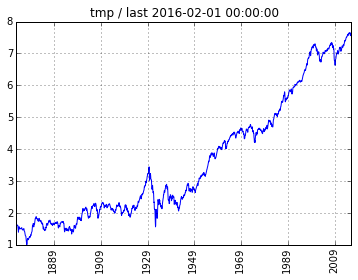

In [15]:
#        log of SPX price:
plot( rawlog.pl )

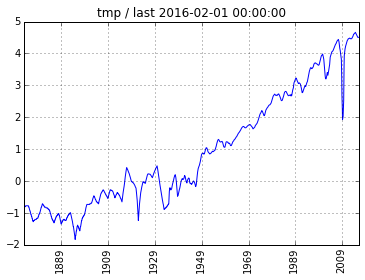

In [16]:
#        log of SPX earnings:
plot( rawlog.xl )

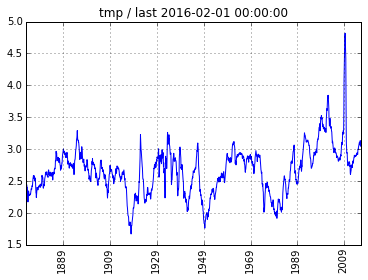

In [17]:
#        log of SPX price/earnings ratio:
plot( rawlog.sl )

Looking for possible outliers, we are struck by the violent downward spike
occuring during the Great Recession in the earnings data.

Looking for possible trends, we can see how the price dynamics
is fundamentally related to earnings growth. In fact,
the **correlation between pl and xl is 0.98** -- which
justifies calling *earnings growth* $X_t$: the **enterprise return**
portion of total return (to be discussed in the final sections).

Prior to 1989, sl looked almost trendless, bouncing roughly
between 2 and 3. Now raw s is the price/earnings ratio,
which is basically the multiplier to earnings at which
an "investor" has implicitly paid at market.
An investor's optimism for a higher re-evaluation,
from other investors, of some given earnings level can
be encapsulated by positive change in the price/earnings rato.
This is the reason behind calling $S_t$
the market's **speculative return**.

In [18]:
#  This is raw price/earnings:
stat( s )

                 Y
count  1742.000000
mean     15.573008
std       8.410519
min       5.310000
25%      11.312500
50%      14.615000
75%      17.830000
max     123.730000


The max on raw price/earnings is 123.73 which is not an
outlier but due to the dramatic drop in earnings
during the Great Recession (quite evident from the plots).
By restricting the datetime index to end at 2000-01-01,
we estimate the all-time mean price/earnings to be around 15
(note $log 15 = 2.71$ and our remark on trendless sl).
The standard deviation drops from 8.4 to 4.6
due to that restriction.

In [19]:
#  Price/earnings prior to the year 2000:
stat( s[:'2000-01-01'] )

                 Y
count  1549.000000
mean     14.248799
std       4.528267
min       5.310000
25%      10.970000
50%      13.860000
75%      17.080000
max      34.000000


## Dividends and the payout ratio

Roughly speaking, dividends are taken out of earnings and paid out to investors.
We are interested in the payout ratio
which will later help give better forecasts of the dividend yield.

In [20]:
#  Dividends paid over 12-months, monthly frequency:
d = get( m4spx_1871_d )

In [21]:
## Uncomment to see raw 12-month dividend:
#  d

In [22]:
#  We want to compute the PAYOUT ratio = dividends/earnings
divearn = todf( d / x )

In [23]:
## Uncomment to see payout ratio data:
#  divearn

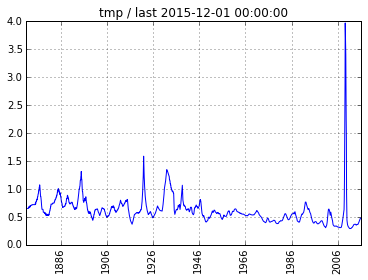

In [24]:
#  Plot payout ratio = dividends/earnings:
plot( divearn )

In [25]:
stat( divearn )

                 Y
count  1740.000000
mean      0.614891
std       0.258620
min       0.288538
25%       0.488346
50%       0.576191
75%       0.686378
max       3.973320


On average, we would expect divearn to be less than 1, since
earnings are the primary source for paying out the dividends.

Sometimes, however, entreprises may hold steady their dividends
while earnings plunge -- for example, during the
Great Recession, the payout ratio went as high as 4.
But as the plot shows this is highly unusual.

Historically we can observe a slight downward trend in the payout ratio
over the very long-term. The mean payout ratio is 0.61.

# TOTAL RETURN for Equities

The total return $T_t$ for equities is composed of the logarithmic price change
plus the dividend yield, over $n$ periods. We shall let $\lambda$ be
the dividend payout ratio relative to earnings $x_i$,
such that the index $i$ is understood to cover periods $t-n$ through $t$.
Thus, we can write:

$$ T_t = P_t + {{\lambda \sum x_i } \over p_{t-n}} $$

Inserting our model in place of $P_t$, we obtain total return as follows:

$$ T_t = X_t + S_t + {{\lambda \sum x_i } \over p_{t-n}} $$

# Forecasting total return

The term lambda $\lambda$ should be a stochastic variable, but we shall
treat it locally as a constant (see plot of divearn).
We utilize the median, rather than the mean, since
that is a far more robust statistic.

To estimate the other variables we localize our data to
the last three years, which gives 36 monthly points of data.

In [26]:
#  For localizing forecasts:
nlocal = 36

#  We can also make "backcasts" by backdating this date variable,
#  or specify a date far in the future to use the most current data:
last = '2100-01-01'

### Estimating future dividend yield

In [27]:
#  Estimated local lambda:
Elambda = np.median( tail(divearn[:last], nlocal) )
Elambda

0.36610350000000003

In [28]:
#  Estimated annualized dividend yield "dy" as percentage:
Edy = Elambda * (tailvalue(x[:last]) / tailvalue(p[:last])) * 100
Edy

1.7441805621724635

Here we used a robust local estimate of lambda,
the dividend payout ratio relative to earnings,
to forecast dividend yield using the "last" known
earnings and price levels.

The history of dividend yields is examined in Appendix 3.

### Estimating earning growth

We tested our model using the change in logarithmic earnings,
so here we will use the geometric mean return on the localized raw data.

The geometric return is akin to our logarithmic model,
and is to be distinguished from the terrible arithmetic return,
though it too can be expressed in percentage form.

In [29]:
#  Get more info by executing: georet??
Xgeoret = georet( tail(x[:last], nlocal), yearly=12 )
Xgeoret

[1.13, 1.21, 4.02, 12, 36, '2013-03-01', '2016-02-01']

In [30]:
#  Geometric return is expressed as percentage,
#  so here is our estimator for big X:
EX = Xgeoret[0]
EX

1.13

### Estimating growth of price/earnings ratio

We tested our model using the change in logarithmic price/earnings ratio,
so here we will use the geometric mean return on the localized raw data.

In [31]:
#  yearly argument in georet annualizes:
Sgeoret = georet( tail(s[:last], nlocal), yearly=12 )
Sgeoret

[5.89, 6.22, 8.19, 12, 36, '2013-03-01', '2016-02-01']

In [32]:
#  Geometric return is expressed as percentage,
#  so here our estimator for big S:
ES = Sgeoret[0]
ES

5.89

## Combining the estimates for a forecast

In terms of our Python variables, here is our model:

$$ \hat{T} = \hat{X} + \hat{S} + \hat{dy} $$

where an "E" prefix is used to represent estimated hat variables.

In [33]:
# FORECAST of TOTAL RETURN, finally...
ET = EX + ES + Edy
ET

8.7641805621724629

In [34]:
print("FORECAST SUMMARY, given 'last' set at", last)
print("TOTAL RETURN (per annum) forecast: ", ET, "%")
print("    - Enterprise return:  ", EX, "%")
print("    - Speculative return: ", ES, "%")
print("    - Dividend yield:     ", Edy, "%")
print("Dividend payout ratio:", Elambda, "(relative to earnings)")
print("Price/earnings ratio, last:", tailvalue( s[:last] ))

FORECAST SUMMARY, given last data point on 2100-01-01
TOTAL RETURN (per annum) forecast:  8.76418056217 %
    - Enterprise return portion of total:   0.128933902261
    - Speculative return portion of total:  0.672053702935
    - Dividend yield portion of total:      0.199012394804
Estimated dividend yield:   1.74418056217 %
Estimated dividend payout ratio: 0.3661035 (relative to earnings)
Last price/earnings ratio: 20.99


### 2016-03-18 Remarks on last="2016-02-01" Forecast

- Enterprise return is weak since earnings growth is below the inflation rate!
- Current price/earnings stands at 21.0 (compared to 15 historically).
- Speculative return portion of projected total return seems very high.

## Appendix 1: Comparison to univariate forecast

Let us apply the Holt-Winters method to logarithmic price alone.
This is a pure time-series technique for the purpose of cross-checking
the multivariate regression model which we used for forecasting.

In [35]:
#  Forecast 12-months ahead:
fc = forecast( plog[:last], h=12 )

In [36]:
## Uncomment to see forecasts:
# fc

In [37]:
#  Change in logarithmic price:
fc.loc[12] - fc.loc[0]

Forecast   -0.053103
dtype: float64

In [38]:
last

'2100-01-01'

2016-03-18: The forecasted price return is about -5.31% per annum,
so adding the estimated dividend yield of +1.74%,
the forecasted total return is -3.57%.
Thus the univariate method on price alone differs considerably from
our multivariate model which forecasted +8.76% for total return.

*Averaging forecasts from different techniques usually increases accuracy.*
Combining the point forecasts for total return from two models:
+2.6% average.


## Appendix 2: Historical enterprise and speculative returns

We examine their respective geometric mean returns
over the entire Shiller database.

In [39]:
#  Enterprise return since 1871:
georet( x, yearly=12 )

[3.62, 4.64, 14.31, 12, 1742, '1871-01-01', '2016-02-01']

In [40]:
#  Speculative return since 1871:
georet( s, yearly=12 )

[0.42, 2.06, 18.1, 12, 1742, '1871-01-01', '2016-02-01']

By examining their geometric mean returns,
we see that enterprise returns (3.62%) contributes far more
to the total return than speculative returns (0.42%).

Our georet() also computes arithmetic mean return
and its standard deviation (second and third
elements respectively). Speculative returns
contributes more volatility in observed
total returns than enterprise returns.

## Appendix 3: Dividend yield historically

Among the three components of total return,
the dividend yield has on average has made
the largest contribution historically.
Also, it has never contributed negatively
to total return.

In [41]:
#  Express dividend yield as percentage per annum:
dy = todf( (d/p) * 100 )

In [42]:
stat( dy )

                 Y
count  1740.000000
mean      4.396557
std       1.686881
min       1.110000
25%       3.220000
50%       4.340000
75%       5.410000
max      13.840000


**The average dividend yield since 1871 has been 4.4% per annum.**
But the plot of the exponentially smoothed values seems to
indicate a steady decline over time.

*Continuance of such a decline in dividend yield would then make
earnings growth the main driver of total return
in the 21st century.*

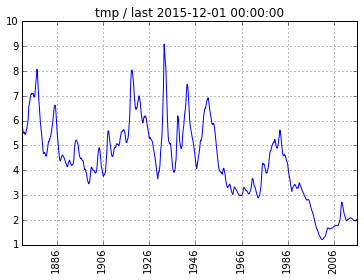

In [43]:
#  History of dividend yields:
plot( ema(dy, alpha=0.10) )
#     ema means Exponential Moving Average.

## References

- Bogle, John C. and Michael W. Nolan, Jr., 2015, "Occam’s Razor Redux: Establishing Reasonable Expectations for Financial Market Returns," *Journal of Portfolio Management* 42, 119-134. http://www.iijournals.com/doi/full/10.3905/jpm.2015.42.1.119 


- Keynes, John Maynard, 1936, *General Theory of Employment, Interest, and Money*, MacMillan, London.

Keynes (1936) enumerated two sources of stock returns: **enterprise** and **speculative**.
Enterprise refers to the actual business results of corporations.
Speculation, on the other hand, involved “forecasting the psychology of the market,”
the ephemeral, emotional response of investors seeking to
anticipate how other investors will react to particular events.

Keynes made no known attempt to quantify the distinction between
enterprise and speculation, so Bogle tackled the task
by developing his BSRM/S model,
"*Bogle Sources of Return Model for Stocks*." 

Bogle (2015) states: 

> *"**The sheer simplicity of the BSRM/S commends it over
highly complex models, none of which (as far as we can determine)
has offered similar accuracy.**"*

This is quite a claim since Bogle
has been involved in finance since 1951 (Princeton honors thesis),
and is the founder of The Vanguard Group.

Bogle (2015) does not show how he arrived at his model mathematically:

> "Although we find this validation of the model gratifying,
we suspect a fit this close to the actual total return has a lot to do with *luck*."

Perhaps he was lucky in terms of small errors between
realized and out-of-samples results,
but the analytics as shown in this notebook is sound.

#### Summary of previous works

John Bogle sought a deeper reasoning behind his expectations
of future total return from a portfolio of equities.
A sample explanation could be phrased as follows:
"I expect annual earning growth of 8%,
and in ten years a terminal price/earning ratio of 14 --
given that ratio is 15.5 currently,
such a 1% reduction per annum will decrease
the total return by like amount.
Therefore, with a dividend yield of 3%,
my expected total return is 8% - 1% + 3% = 10%
over the coming decade."

This notebook shows the (arithmetic) percentage reasoning
is prone is large errors, whereas a logarithmic (geometric) version
is exact. Shiller's reconstructed data since 1871 allows us to examine
the separable components of total return:
enterprise and speculative returns, plus dividend yield.
An understanding of their respective contributions
helps us to form better informed expectations of
future total return on equities.
